###Step 1: Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


###Step 2 : Load the dataset

In [4]:
df=pd.read_csv("/content/olist_orders_dataset.csv")
print(df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None


###Step 3: Convert date columns

In [6]:
# Convert date columns to datetime safely
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows without delivered date
df = df.dropna(subset=['order_delivered_customer_date'])


###Step 4: Create target: delivery_time_days

In [7]:
# Delivery time in days (delivered - purchase)
df['delivery_time_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Remove negatives
df = df[df['delivery_time_days'] >= 0]

print(df[['order_purchase_timestamp', 'order_delivered_customer_date', 'delivery_time_days']].head())


  order_purchase_timestamp order_delivered_customer_date  delivery_time_days
0      2017-10-02 10:56:33           2017-10-10 21:25:13                   8
1      2018-07-24 20:41:37           2018-08-07 15:27:45                  13
2      2018-08-08 08:38:49           2018-08-17 18:06:29                   9
3      2017-11-18 19:28:06           2017-12-02 00:28:42                  13
4      2018-02-13 21:18:39           2018-02-16 18:17:02                   2


###Step 5: Make some simple features

In [8]:
# Time-based features
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['is_weekend'] = df['purchase_dayofweek'].isin([5,6]).astype(int)

# Estimated delivery days (estimate - purchase)
df['estimated_delivery_days'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days


###Step 6: Prepare data for the model

In [9]:
# Features (X) and target (y)
X = df[['purchase_hour', 'purchase_dayofweek', 'is_weekend', 'estimated_delivery_days']]
y = df['delivery_time_days']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


###Step 7: Train the model

In [10]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


###Step 8: Evaluate the model


In [12]:
rmse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

RMSE: 87.16233001321154
MAE: 5.6622949204620445
R²: 0.12987201435295348


###Step 9: Plot the results

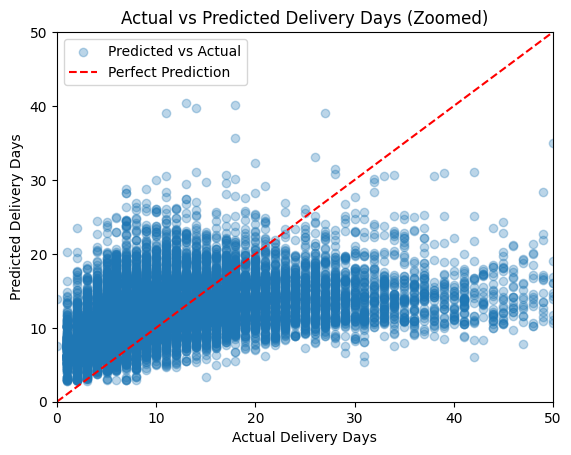

In [15]:
plt.scatter(y_test, y_pred, alpha=0.3, label='Predicted vs Actual')

# Limit axes to focus on most common delivery times (e.g., 0–50 days)
plt.xlim(0, 50)
plt.ylim(0, 50)

# Add perfect prediction line
plt.plot([0, 50], [0, 50], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual Delivery Days")
plt.ylabel("Predicted Delivery Days")
plt.title("Actual vs Predicted Delivery Days (Zoomed)")
plt.legend()
plt.show()
